In [1]:
%load_ext autoreload

In [66]:
%autoreload 2

In [3]:
import sys
sys.path.append('../..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from random import random
from datetime import datetime
from tqdm import tqdm

from config import client
from mlpp.data_collection import curve_utils
from mlpp.data_collection.sample import ScoresSubset
from mlpp.data_collection.sample_func import displacement_err, SampleConfig, SampleFunctionGenerator as SFG

In [27]:
NUM_BINS = 200
MAX_PP = 20000
DATE_LIMIT = datetime(2019,1,1)
SAMPLE_CONFIG = SampleConfig(date_limit = DATE_LIMIT, max_pp = MAX_PP, n_bins = NUM_BINS)

osu_random_db = client['osu_random_db']
osu_subset = ScoresSubset(osu_random_db['osu_scores_high'], osu_random_db['osu_user_stats'])
subset_3k = ScoresSubset(osu_random_db['scores_sample_3k'], osu_random_db['users_sample_3k'])

generator = SFG(osu_subset, SAMPLE_CONFIG)

In [28]:
greedy_policy, predicted_uniformity_arr, bins_hist = generator.greedy(.01)

100%|██████████| 200/200 [00:33<00:00,  6.04it/s]


In [29]:
# np.save("greedy_sample_func_1_pcnt.npy", greedy_sample_policy)

In [30]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

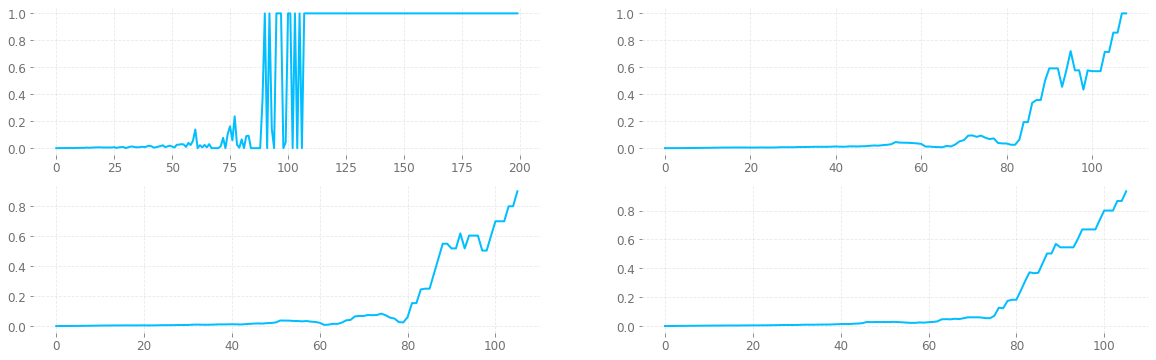

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 6))
axes[0][0].plot(greedy_policy)

t3 = ((115, 7), (115, 10), (120, 15))
transform = lambda t: moving_average(greedy_policy[:t[0]], t[1])

smoothed_policies = list(map(transform, t3))

axes[0][1].plot(smoothed_policies[0])
axes[1][0].plot(smoothed_policies[1])
axes[1][1].plot(smoothed_policies[2])

In [67]:
x1 = np.arange(NUM_BINS) * MAX_PP/ NUM_BINS

def policy_to_linear(p): 
    f1 = curve_utils.linear_expon_fit(x1[:len(p)], p)
    return lambda x: np.clip(f1(x), 0, 1)

linear_exp_funcs = list(map(policy_to_linear, smoothed_policies))

a:-6.9240535180538325 b:0.0006507155848702727, e^(a + bx)
a:-6.978780325607734 b:0.0006665255563976963, e^(a + bx)
a:-6.747232538332549 b:0.0006546892235855183, e^(a + bx)


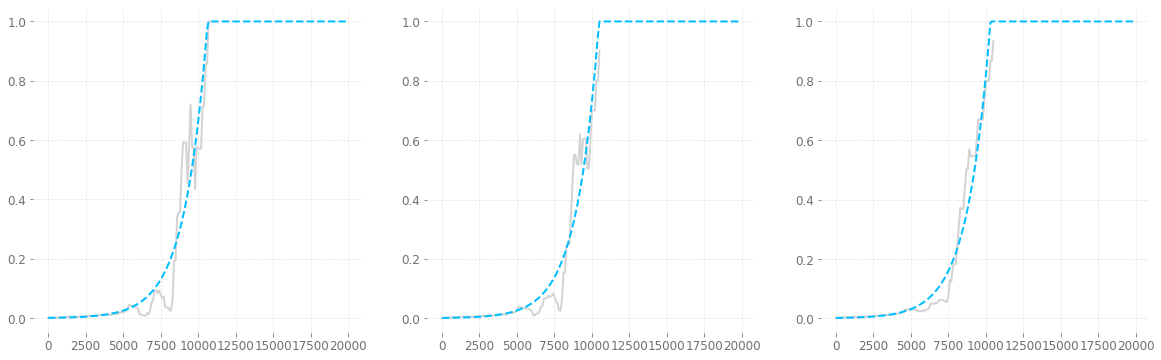

In [42]:
BINS = x1 * (MAX_PP / NUM_BINS)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

for i in range(3):
    po = smoothed_policies[i]
    pf = linear_exp_funcs[i]
    axes[i].plot(x1[:len(po)], po, color='lightgray', label = 'original')
    axes[i].plot(x1, pf(x1), linestyle = 'dashed', label = f'w-size: {t3[i]}')

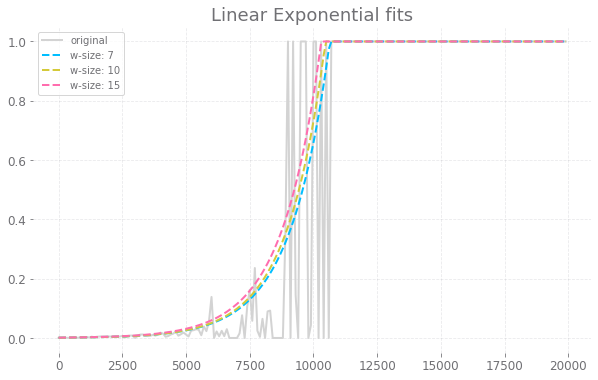

In [43]:
plt.figure(figsize=(10, 6))

plt.plot(x1, greedy_policy, color='lightgray', label = 'original')
for i in range(3):
    pf = linear_exp_funcs[i]
    plt.plot(x1, pf(x1), linestyle = 'dashed', label = f'w-size: {t3[i][1]}')

plt.title("Linear Exponential fits")
plt.legend(loc='upper left')

../../mlpp/data_collection/curve_utils.py:11: RuntimeWarning: invalid value encountered in power
  return a * np.power(b, c * x)
../../mlpp/data_collection/curve_utils.py:11: RuntimeWarning: overflow encountered in power
  return a * np.power(b, c * x)


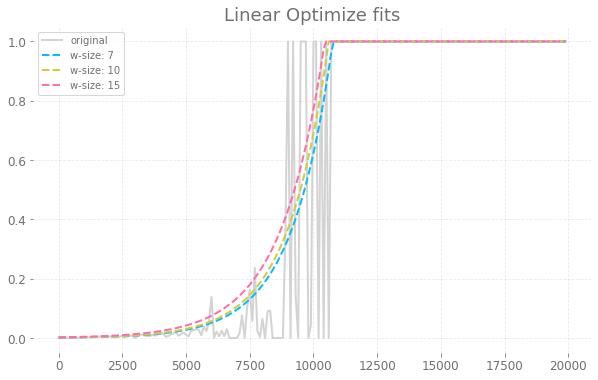

In [44]:
p0 = (1.68881617e-03, 1.00011615e+00, 6.36903398e-02) # from experimentation

def policy_to_opt(po):
    f1 = curve_utils.optimize_expon_fit(x1[:len(po)], po, p0)
    return lambda x: np.clip(f1(x), 0, 1)

opt_funcs = list(map(policy_to_opt, smoothed_policies))

plt.figure(figsize=(10, 6))

plt.plot(x1, greedy_policy, color='lightgray', label = 'original')
for i in range(3):
    pf = opt_funcs[i]
    plt.plot(x1, pf(x1), linestyle = 'dashed', label = f'w-size: {t3[i][1]}')

plt.title("Linear Optimize fits")
plt.legend(loc='upper left')

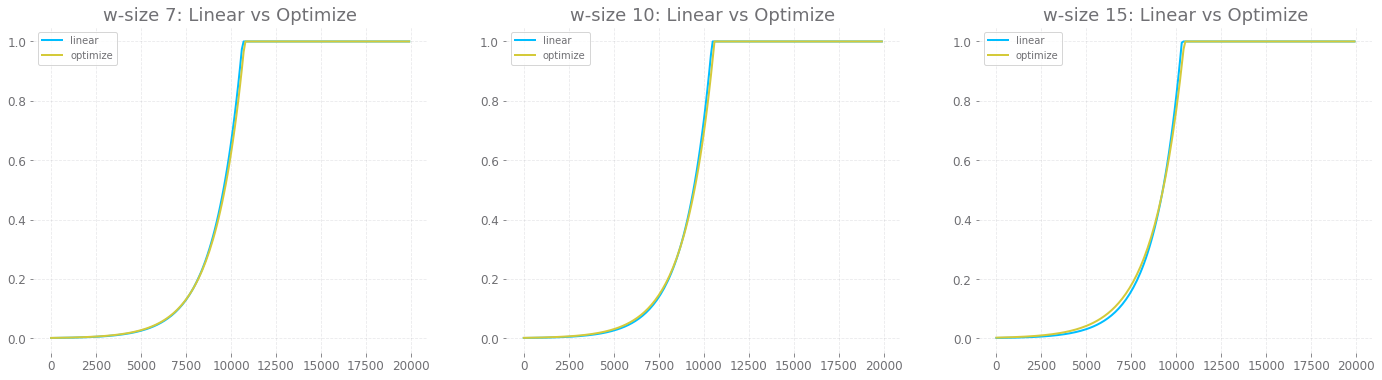

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

for i in range(3):
    axs[i].set_title(f"w-size {t3[i][1]}: Linear vs Optimize")
    axs[i].plot(x1, linear_exp_funcs[i](x1), label = 'linear')
    axs[i].plot(x1, opt_funcs[i](x1), label = 'optimize')
    axs[i].legend(loc = 'upper left')

In [13]:
greedy_trials = {}
greedy_trials['fit'] = [f'optimize w-{w}' for _, w in t3] + [f'linear w-{w}' for _, w in t3]

In [14]:
for i in range(4):
    samples_pp = [osu_subset.simulate(fit, SAMPLE_CONFIG) for fit in tqdm(opt_funcs + linear_exp_funcs)]
    greedy_trials[f'trial{i + 1}'] = list(map(displacement_err, samples_pp))

100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


In [15]:
df = pd.DataFrame(greedy_trials)
col = df.loc[:, 'trial1': 'trial4']
df['mean'] = col.mean(axis=1)

df.style.highlight_min(color = 'blue', axis = 0) 

,fit,trial1,trial2,trial3,trial4,mean
0,optimize w-5,0.207631,0.213967,0.167713,0.192104,0.195354
1,optimize w-10,0.168768,0.111391,0.092326,0.162604,0.133772
2,optimize w-15,0.118497,0.109117,0.139974,0.126620,0.123552
3,linear w-5,0.120937,0.149211,0.161399,0.172131,0.150920
4,linear w-10,0.152212,0.136524,0.103997,0.150854,0.135897
5,linear w-15,0.101770,0.097649,0.126568,0.094742,0.105182


In [60]:
greedy_best_func = linear_exp_funcs[2]

generator_3k = SFG(subset_3k, SAMPLE_CONFIG)
pdf_func = generator.pdf(st.recipinvgauss, .02)

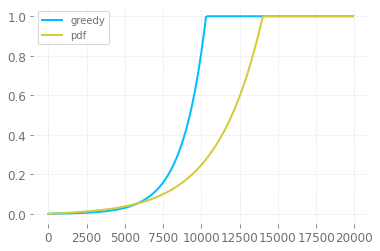

In [61]:
plt.plot(x1, greedy_best_func(x1), label = "greedy")
plt.plot(x1, pdf_func(x1), label = "pdf")
plt.legend(loc = "upper left")

In [18]:
def test_fit(func, subset = osu_subset, cnt = 10):
    size = err_cnt = 0
    for i in tqdm(range(cnt)):
        sample_pp = subset.simulate(func, SAMPLE_CONFIG)
        err_cnt += displacement_err(sample_pp)
        size += len(sample_pp)
    
    print(f'\navg error: {err_cnt / cnt}')
    print(f'\navg sample size: {size / cnt}')

In [64]:
test_fit(greedy_best_func)

100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


avg error: 0.220437393968814

avg sample size: 103222.5


In [62]:
test_fit(pdf_func)

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


avg error: 0.2480249835963389

avg sample size: 84602.2


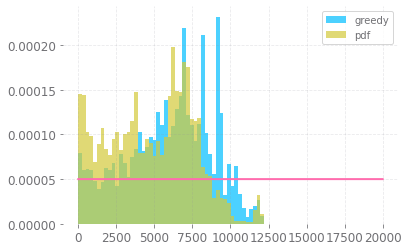

In [63]:
_ = plt.hist(osu_subset.simulate(greedy_best_func, SAMPLE_CONFIG), bins = 50, density = True, alpha=0.7, label='greedy')
_ = plt.hist(osu_subset.simulate(pdf_func, SAMPLE_CONFIG), bins = 50, density = True, alpha=0.7, label='pdf')
_ = plt.plot(np.arange(0,MAX_PP), np.full(MAX_PP, 1/MAX_PP))
plt.legend(loc='upper right')

In [22]:
val_random_db = client['val_random_db']
val_subset = ScoresSubset(val_random_db.osu_scores_high, val_random_db.osu_user_stats)

In [23]:
test_fit(greedy_best_func, val_subset, 50)

100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


avg error: 0.17971665195115313

avg sample size: 39155.38


In [24]:
test_fit(pdf_func, val_subset, 50)

100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


avg error: 0.1674173741527233

avg sample size: 36291.64


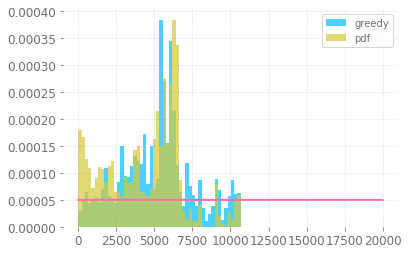

In [65]:
_ = plt.hist(val_subset.simulate(greedy_best_func, SAMPLE_CONFIG), bins = 50, density = True, alpha=0.7, label='greedy')
_ = plt.hist(val_subset.simulate(pdf_func, SAMPLE_CONFIG), bins = 50, density = True, alpha=0.7, label='pdf')
_ = plt.plot(np.arange(0,MAX_PP), np.full(MAX_PP, 1/MAX_PP))
plt.legend(loc='upper right')

In [ ]:
np.save("greedy_sample_func.npy", greedy_best_fit)
np.save("pdf_sample_func.npy", pdf_fit)